In [1]:
from srcmap import *
from mask import *
from stack import *
from utils_plotting import *
import seaborn as sns
sns.set()

In [2]:
inst = 1
make_srcmap_class = make_srcmap(inst, Re2 = 2, m_max=17)

In [3]:
mags = np.random.uniform(16, 17, len(make_srcmap_class.ms))
xls = np.random.uniform(0, 1023, len(make_srcmap_class.ms))
yls = np.random.uniform(0, 1023, len(make_srcmap_class.ms))

make_srcmap_class.ms = mags
make_srcmap_class.ms_inband = mags
make_srcmap_class.xls = xls
make_srcmap_class.yls = yls

In [4]:
mzmask, mznum = MZ14_mask(inst, xls, yls, mags)
clear_output()

srcmap = make_srcmap_class.run_srcmap(ptsrc=True)
modmap = make_srcmap_class.run_srcmap(ptsrc=False)

clear_output()

In [6]:
stack_class = stacking_mock(inst, make_srcmap_class.m_min, make_srcmap_class.m_max)
stack_class.xls = xls
stack_class.yls = yls

stacks, maskstacks, mapstacks = stack_class.run_stacking\
(srcmap - np.mean(srcmap[mzmask==1]), mzmask, mznum)

stackm, maskstackm, mapstackm = stack_class.run_stacking\
(modmap - np.mean(modmap[mzmask==1]), mzmask, mznum)

clear_output()

In [17]:
# data
dx = make_srcmap_class.dx
profstacks = radial_prof(stacks, dx, dx)
profstackm = radial_prof(stackm, dx, dx)

#model
psf_map = make_srcmap_class.psf_map
mod_map = make_srcmap_class.modconv_map
pix_map = make_srcmap_class.pix_map
Npad = (psf_map.shape[0] - pix_map.shape[0])//2
pix_map = np.pad(pix_map, ((Npad,Npad),(Npad,Npad)), 'constant')
psfwin_map = fftconvolve(psf_map, pix_map, 'same')
modwin_map = fftconvolve(mod_map, pix_map, 'same')
profmodelm = radial_prof(modwin_map, dx, dx)
profmodels = radial_prof(psfwin_map, dx, dx)

# excess
r_arr = profmodels['rbins']
stackex_arr = profstackm['prof']/profstackm['prof'][0] - profstacks['prof']/profstacks['prof'][0]
modelex_arr = profmodelm['prof']/profmodelm['prof'][0] - profmodels['prof']/profmodels['prof'][0]

make_srcmap_class1 = make_srcmap(inst, Re2 = 1.5, m_max=17)
modwin_map1 = fftconvolve(make_srcmap_class1.modconv_map, pix_map, 'same')
profmodelm1 = radial_prof(modwin_map1, dx, dx)
modelex_arr1 = profmodelm1['prof']/profmodelm1['prof'][0] - profmodels['prof']/profmodels['prof'][0]

make_srcmap_class2 = make_srcmap(inst, Re2 = 2.5, m_max=17)
modwin_map2 = fftconvolve(make_srcmap_class2.modconv_map, pix_map, 'same')
profmodelm2 = radial_prof(modwin_map2, dx, dx)
modelex_arr2 = profmodelm2['prof']/profmodelm2['prof'][0] - profmodels['prof']/profmodels['prof'][0]

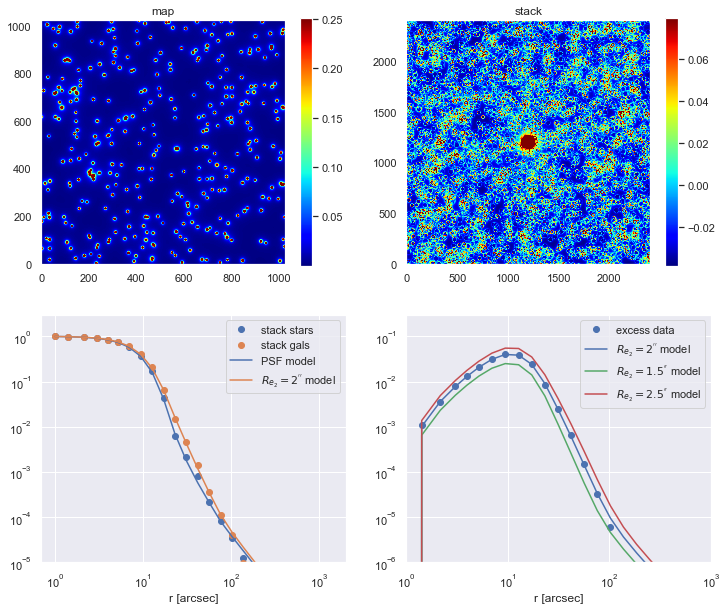

In [21]:
fig, ax = plt.subplots(2,2,figsize=(12,10))

imageclip(srcmap, ax=ax[0][0])
ax[0][0].set_title('map')
ax[0][0].grid(False)
imageclip(stacks, ax=ax[0][1])
ax[0][1].set_title('stack')
ax[0][1].grid(False)

ax[1][0].loglog(r_arr,profstacks['prof']/profstacks['prof'][0],'C0o',label='stack stars')
ax[1][0].loglog(r_arr,profstackm['prof']/profstackm['prof'][0],'C1o',label='stack gals')
ax[1][0].loglog(r_arr,profmodels['prof']/profmodels['prof'][0],'C0',
             label='PSF model')
ax[1][0].loglog(r_arr,profmodelm['prof']/profmodelm['prof'][0],'C1',
             label=r"$R_{e_2}=2^{''}$ model")
ax[1][0].set_ylim([1e-5,3e0])
ax[1][0].set_xlabel('r [arcsec]')
ax[1][0].legend()

ax[1][1].loglog(r_arr,stackex_arr,'C0o',label='excess data')
ax[1][1].loglog(r_arr,modelex_arr,'C0',label=r"$R_{e_2}=2^{''}$ model")
ax[1][1].loglog(r_arr,modelex_arr1,'C2',label=r"$R_{e_2}=1.5^{''}$ model")
ax[1][1].loglog(r_arr,modelex_arr2,'C3',label=r"$R_{e_2}=2.5^{''}$ model")

ax[1][1].set_ylim([1e-6,3e-1])
ax[1][1].set_xlim([1e0,1e3])
ax[1][1].legend()
ax[1][1].set_xlabel('r [arcsec]')
plt.savefig('plots/fitting_process_test.png', dpi = 100, bbox_inches='tight')